In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

from scipy import linalg
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Part 1A: Kalman Filters in Time Series Analysis

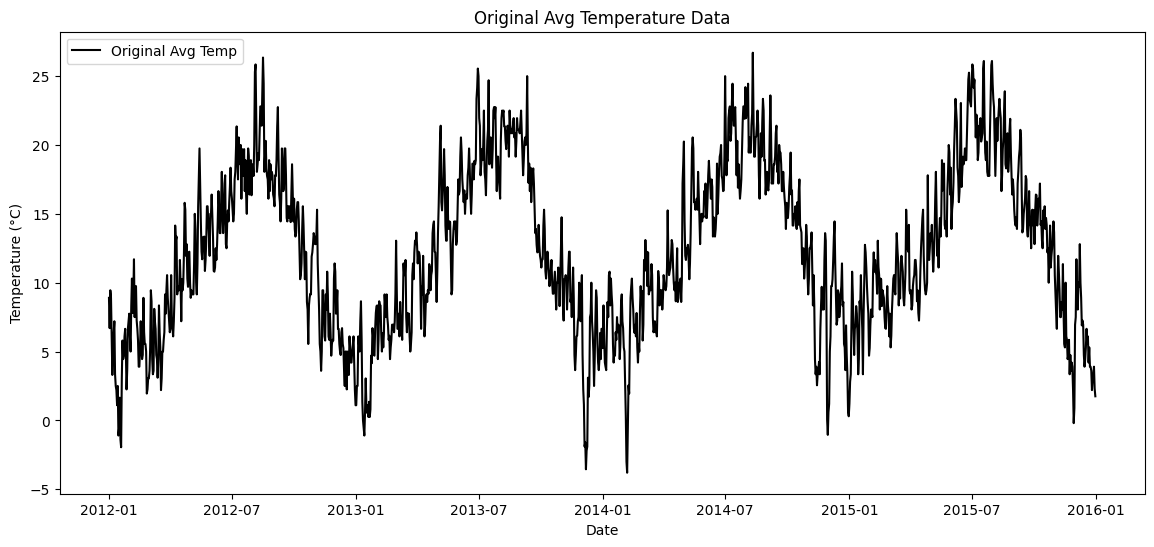

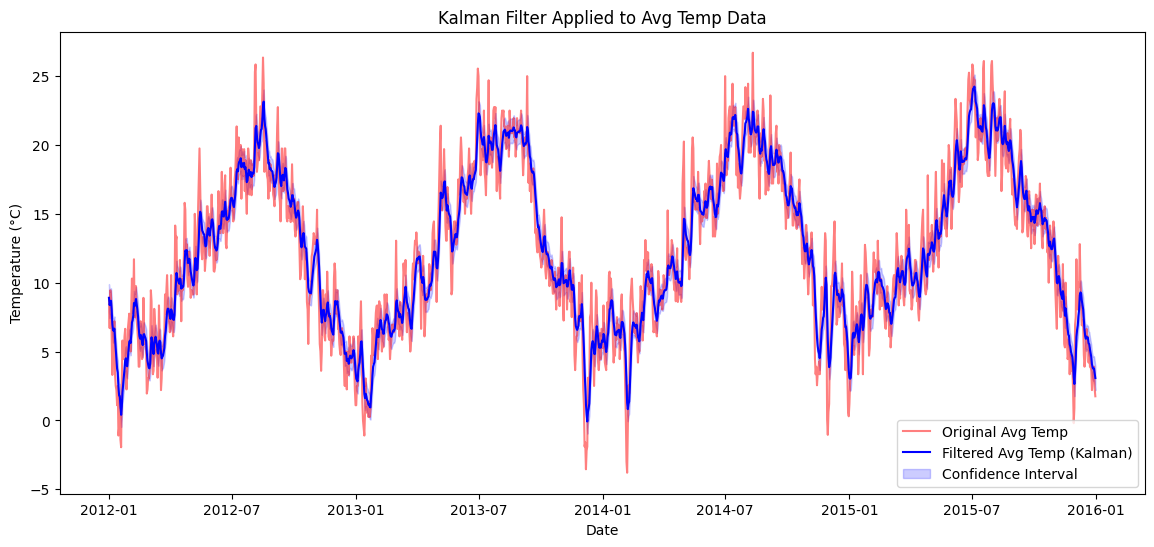

In [69]:
class KalmanFilter:
    def __init__(self, alpha, q, r, initial_state, initial_variance):
        """
        Initializes the Kalman filter with parameters.
        
        Args:
            alpha (float): State transition coefficient.
            q (float): Process noise standard deviation.
            r (float): Measurement noise standard deviation.
            initial_state (float): Initial state estimate.
            initial_variance (float): Initial error covariance.
        """
        self.alpha = alpha
        self.q = q
        self.r = r
        self.mu = initial_state
        self.sigma = initial_variance

    def filter(self, data):
        """
        Applies the Kalman filter to the input data.
        
        Args:
            data (np.array): The data array to filter.
        
        Returns:
            mu_filtered (np.array): Array of filtered state estimates.
            sigma_filtered (np.array): Array of filtered variances.
        
        TODO:
        - Implement the prediction and update steps of the Kalman filter.
        """
        T = len(data)
        mu_filtered = np.zeros(T)
        sigma_filtered = np.zeros(T)
        mu_filtered[0] = self.mu
        sigma_filtered[0] = self.sigma

        for t in range(1, T):
            # TODO: Implement prediction step
            mu_prior = self.alpha * mu_filtered[t - 1]  # Replace with: μ_prior_t = α * μ_t-1
            sigma_prior = (self.alpha ** 2) * sigma_filtered[t - 1] + (self.q ** 2) # Replace with: σ_prior_t = q^2 + (α^2) * σ_t-1

            # TODO: Implement update step
            K = sigma_prior/ (sigma_prior + (self.r ** 2))  # Replace with: σ_prior_t / (σ_prior_t + r^2)
            mu_filtered[t] = mu_prior + (K*(data[t] - mu_prior))  # Replace with: μ_t = μ_prior_t + K_t * (data_t - μ_prior_t)
            sigma_filtered[t] = (1 - K) * sigma_prior  # Replace with: σ_t = (1 - K_t) * σ_prior_t

        return mu_filtered, sigma_filtered

    def plot_results(self, dates, data, mu_filtered, sigma_filtered):
        """
        Plots the original and filtered data along with the confidence interval.
        
        Args:
            dates (pd.Index): Date index for the data.
            data (np.array): Original data.
            mu_filtered (np.array): Filtered state estimates.
            sigma_filtered (np.array): Filtered variances.
        """
        plt.figure(figsize=(14, 6))
        plt.plot(dates, data, label='Original Avg Temp', color='red', alpha=0.5)
        plt.plot(dates, mu_filtered, label='Filtered Avg Temp (Kalman)', color='blue')
        plt.fill_between(dates, mu_filtered + sigma_filtered, mu_filtered - sigma_filtered, color='blue', alpha=0.2, label='Confidence Interval')
        plt.title('Kalman Filter Applied to Avg Temp Data')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()

# Main function with TODOs for students to complete
if __name__ == "__main__":
    # TODO: Load the dataset and preprocess it
    weather_df = pd.read_csv('./seattle-weather.csv', parse_dates=['date'], index_col='date') # TODO Load the data using the 'parse_dates' and 'index_col' arguments
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()  # TODO: Select 'temp_max', 'temp_min', and 'weather' columns and drop NaN values
    
    # Calculate the average temperature
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2.0  # TODO: Calculate the average temperature 
    
    # Plot the original average temperature data
    plt.figure(figsize=(14, 6))
    plt.plot(weather_df.index, weather_df['temp_avg'], label='Original Avg Temp', color='black')
    plt.title('Original Avg Temperature Data')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()

    # TODO: Set Kalman filter parameters
    alpha = 1  
    q = 0.5  
    r = 2  
    initial_state = weather_df['temp_avg'].values[0]  # Initial state estimate
    initial_variance = 1  # Initial error covariance

    # Initialize the Kalman filter
    kf = KalmanFilter(alpha, q, r, initial_state, initial_variance)

    # Run the Kalman filter on the temperature data
    temp_avg_data = weather_df['temp_avg'].values
    mu_filtered, sigma_filtered = kf.filter(temp_avg_data)

    # Plot results
    kf.plot_results(weather_df.index, temp_avg_data, mu_filtered, sigma_filtered)
    
   


In [70]:
kalman_mae = mean_absolute_error(temp_avg_data, mu_filtered)
kalman_rmse = np.sqrt(mean_squared_error(temp_avg_data, mu_filtered))

kalman_metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE"],
    "Kalman Filter": [kalman_mae, kalman_rmse]
})

kalman_metrics_df

,Metric,Kalman Filter
0,MAE,1.438011
1,RMSE,1.828645


### **Kalman Filter Discussion**

The Kalman Filter performed very well as a smoother, The original temperature data is highly noisy showing large day to day fluctuations and the Kalman output is slightly smoother, capturing the underlying seasonal pattern (winter to summer to winter) without overreacting to every noisy spike. 

An MAE of 1.44 means that, on average, the filter’s estimates differ from the true temperature by less than one and a half degrees, a strong performance for noisy daily weather data. An RMSE of 1.83 suggests that even larger deviations remain relatively small. The filter is therefore not only smoothing effectively but also providing accurate short-term predictions, capturing both trend and seasonality while suppressing unpredictable fluctuations.

The confidence interval was effective in depicting the variability of the filtered estimates. The uncertainty band appropriately widened during periods where the observations fluctuated more sharply and narrowed when the system exhibited stable temperature trends.

## Part 1B: Hidden Markov Models (HMMs) in Time Series Analysis


Train State Comparison:
   Actual State  Predicted State
0             0                1
1             1                1
2             1                3
3             1                3
4             1                1

Test State Comparison:
   Actual State  Predicted State
0             1                1
1             1                3
2             1                3
3             1                3
4             2                4

HMM Performance:
Training Set Accuracy: 30.57%
Testing Set Accuracy: 37.88%


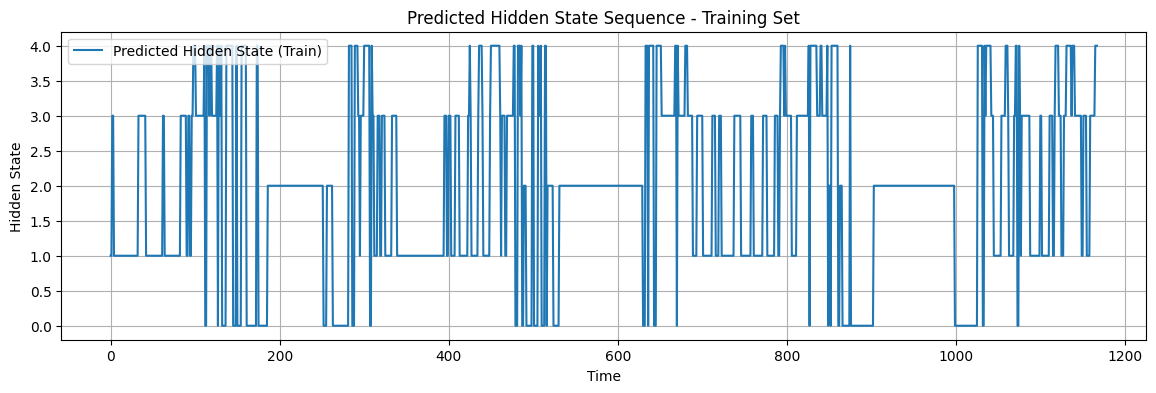

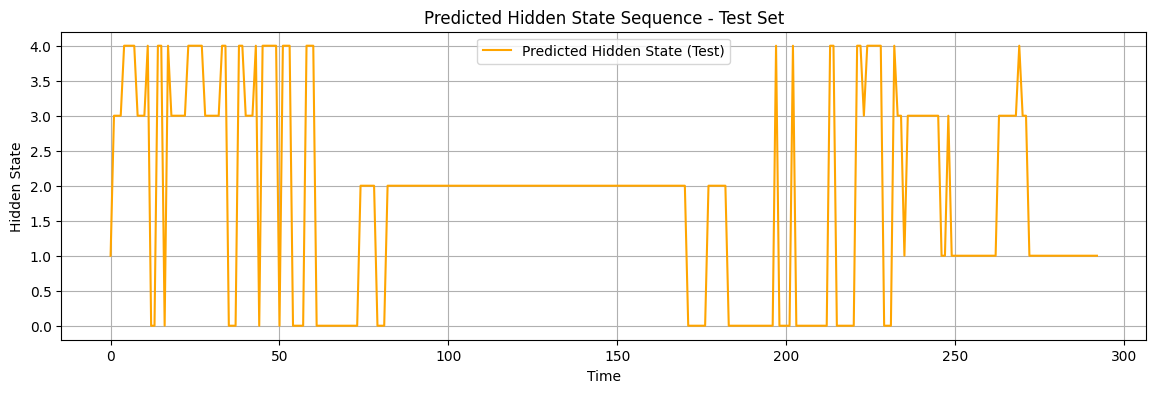

In [71]:
class HiddenMarkovModel:
    def __init__(self, num_states, num_observations):
        """
        Initializes the HMM with random transition, emission, and initial state probabilities.
        
        Args:
            num_states (int): Number of hidden states.
            num_observations (int): Number of unique observations.
        """
        self.num_states = num_states
        self.num_observations = num_observations
        self.A = np.random.dirichlet(np.ones(num_states), num_states)  # Transition matrix
        self.B = np.random.dirichlet(np.ones(num_observations), num_states)  # Emission matrix
        self.pi = np.random.dirichlet(np.ones(num_states))  # Initial state distribution
        
        # Log-space versions to avoid underflow
        self.A_log = np.log(self.A + 1e-10)
        self.B_log = np.log(self.B + 1e-10)
        self.pi_log = np.log(self.pi + 1e-10)

    def forward_algorithm_log(self, O):
        """
        Forward algorithm in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            alpha_log (np.array): Log-probability matrix of forward probabilities.
        
        TODO:
        - Implement the forward algorithm initialization and recursion in log-space.
        """
        T = len(O)
        N = self.num_states
        alpha_log = np.zeros((T, N))

        # TODO: Initialization step
        alpha_log[0] = self.pi_log + self.B_log[:, O[0]] # Replace with initialization logic: log(α_0) = log(π) + log(B[:, O_0])

        # TODO: Recursion step
        for t in range(1, T):
            for j in range(N):
                alpha_log[t, j] = np.logaddexp.reduce(alpha_log[t-1] + self.A_log[:, j]) + self.B_log[j, O[t]]  # Replace with recursion logic

        return alpha_log

    def backward_algorithm_log(self, O):
        """
        Backward algorithm in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            beta_log (np.array): Log-probability matrix of backward probabilities.
        
        TODO:
        - Implement the backward algorithm initialization and recursion in log-space.
        """
        T = len(O)
        N = self.num_states
        beta_log = np.zeros((T, N))

        # TODO: Initialization step
        beta_log[-1] = 0  # log(1) = 0

        # TODO: Recursion step
        for t in range(T - 2, -1, -1):
            for i in range(N):
                beta_log[t, i] = np.logaddexp.reduce(self.A_log[i] + self.B_log[:, O[t+1]] + beta_log[t+1])  # Replace with recursion logic

        return beta_log

    def baum_welch_log(self, O, max_iter=100, epsilon=1e-6):
        """
        Baum-Welch algorithm for training HMM in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
            max_iter (int): Maximum number of iterations.
            epsilon (float): Small value to prevent division by zero.
        
        Returns:
            Trained transition, emission, and initial state distributions.
        
        TODO:
        - Implement the update steps for transition and emission probabilities.
        """
        T = len(O)
        
        for iteration in range(max_iter):
            # TODO: Call forward_algorithm_log and backward_algorithm_log
            alpha_log = self.forward_algorithm_log(O) # Call forward algorithm
            beta_log = self.backward_algorithm_log(O) # Call backward algorithm
            
            # Compute gamma and xi in log-space
            gamma_log = alpha_log + beta_log - np.logaddexp.reduce(alpha_log[-1])
            xi_log = np.zeros((T - 1, self.num_states, self.num_states))

            for t in range(T - 1):
                denom_log = np.logaddexp.reduce((alpha_log[t][:, None]+ self.A_log+ self.B_log[:, O[t+1]][None, :]+ beta_log[t+1][None, :]).ravel())  # Replace with logic for computing the denominator
                for i in range(self.num_states):
                    for j in range(self.num_states):
                        xi_log[t, i, j] = alpha_log[t, i] + self.A_log[i, j] + self.B_log[j, O[t+1]] + beta_log[t+1, j] - denom_log  # Replace with logic for computing xi_log

            # TODO: Update A_log, B_log, and pi_log
            
            self.A_log = np.logaddexp.reduce(xi_log, axis=0) - np.logaddexp.reduce(gamma_log[:-1], axis=0)[:, None]  # Replace with logic for updating A_log

            self.B_log = (np.array([ np.logaddexp.reduce(gamma_log[O == k], axis=0) if np.any(O == k) else -np.inf for k in range(self.num_observations) ]).T
                        - np.logaddexp.reduce(gamma_log, axis=0)[:, None]) # Replace with logic for updating B_log

            self.pi_log = gamma_log[0] # Replace with logic for updating pi_log

        return np.exp(self.A_log), np.exp(self.B_log), np.exp(self.pi_log)

    def viterbi_algorithm_log(self, O):
        """
        Viterbi algorithm for finding the most likely state sequence in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            states (np.array): Most likely state sequence.
        
        TODO:
        - Implement the Viterbi algorithm's initialization and recursion steps.
        """
        T = len(O)
        N = self.num_states
        delta_log = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)

        # TODO: Initialization step
        delta_log[0] = self.pi_log + self.B_log[:, O[0]]  # Replace with initialization logic

        # TODO: Recursion step
        for t in range(1, T):
            for j in range(N):
                delta_log[t, j] = np.max(delta_log[t-1] + self.A_log[:, j]) + self.B_log[j, O[t]]  # Replace with recursion logic
                psi[t, j] = np.argmax(delta_log[t-1] + self.A_log[:, j])  # Replace with logic for tracking the path

        # TODO: Path backtracking
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta_log[-1])  # Replace with logic for the final state
        for t in range(T - 2, -1, -1):
            states[t] = psi[t + 1, states[t + 1]]  # Replace with path backtracking logic

        return states

# Main function with TODOs for students to complete
if __name__ == "__main__":
    # Load and preprocess the weather dataset
    weather_df = pd.read_csv('./seattle-weather.csv', parse_dates=['date'], index_col='date') # TODO Load the data using the 'parse_dates' and 'index_col' arguments
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()  # TODO: Select 'temp_max', 'temp_min', and 'weather' columns and drop NaN values
  

    # Calculate the average temperature and encode the 'weather' column
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2.0  #TODO Calculate the average temperature

    weather_mapping = {label: idx for idx, label in enumerate(weather_df['weather'].unique())}
    reverse_weather_mapping = {v: k for k, v in weather_mapping.items()}
    weather_df['weather_encoded'] = weather_df['weather'].map(weather_mapping)

    # Convert average temperature to integer values for the observation sequence
    temp_min = weather_df['temp_avg'].min()
    O = (weather_df['temp_avg'] - temp_min).astype(int).values  # Observation sequence

    # Split data into training and testing sets
    train_size = int(0.8 * len(O))
    O_train = O[:train_size]
    O_test = O[train_size:]
    actual_train = weather_df['weather_encoded'].values[:train_size]
    actual_test = weather_df['weather_encoded'].values[train_size:]

    # Initialize and train the HMM
    num_states = len(weather_mapping)
    num_observations = O.max() + 1
    hmm = HiddenMarkovModel(num_states, num_observations)

    # TODO: Train the HMM using Baum-Welch on training data
    A_trained, B_trained, pi_trained = hmm.baum_welch_log(O_train)

    # TODO: Use the Viterbi algorithm for decoding the most likely state sequence
    train_predicted_states =  hmm.viterbi_algorithm_log(O_train)
    test_predicted_states =  hmm.viterbi_algorithm_log(O_test)

    # Decode predicted states
    train_decoded_states = np.array([reverse_weather_mapping[s] for s in train_predicted_states])
    test_decoded_states = np.array([reverse_weather_mapping[s] for s in train_predicted_states]) 

    # TODO: Create and display comparison DataFrames for train and test sets
    
    train_df = pd.DataFrame({
        "Actual State": actual_train,
        "Predicted State": train_predicted_states
    })

    test_df = pd.DataFrame({
        "Actual State": actual_test,
        "Predicted State": test_predicted_states
    })

    print("\nTrain State Comparison:")
    print(train_df.head())

    print("\nTest State Comparison:")
    print(test_df.head())

    # TODO: Evaluate accuracy for training and testing sets
    train_accuracy = np.mean(train_predicted_states == actual_train) 
    test_accuracy = np.mean(test_predicted_states == actual_test)

    print("\nHMM Performance:")
    print(f"Training Set Accuracy: {train_accuracy:.2%}")
    print(f"Testing Set Accuracy: {test_accuracy:.2%}")
    
    # Plot hidden state sequence for training data
    plt.figure(figsize=(14, 4))
    plt.plot(train_predicted_states, label="Predicted Hidden State (Train)")
    plt.title("Predicted Hidden State Sequence - Training Set")
    plt.xlabel("Time")
    plt.ylabel("Hidden State")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot hidden state sequence for test data
    plt.figure(figsize=(14, 4))
    plt.plot(test_predicted_states, label="Predicted Hidden State (Test)", color='orange')
    plt.title("Predicted Hidden State Sequence - Test Set")
    plt.xlabel("Time")
    plt.ylabel("Hidden State")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    


### **HMM and Viterbi Algorithm Discussion**

The comparison tables for both the training and testing sets reveal that the Hidden Markov Model (HMM) frequently predicts hidden states that do not match the actual observed weather categories. As a result, the training accuracy of 30.57% is remarkably low, actually falling slightly below the threshold of random chance for a three-state model 33%. The testing accuracy of 37.88% is marginally higher but remains poor, confirming that the model has not learned to distinguish the specific weather types you defined.


The most significant limitation is that a standard HMM assumes the probability of tomorrow's weather depends only on today's weather state. Weather systems have "momentum" and long-term dependencies and the HMM ignores these long-term historical patterns. Additionally, the HMM is unsupervised. It groups data based on statistical similarity, not semantic meaning. It might group Cold Sunny Days and Cold Snowy Days into the same state because their temperatures are similar, effectively making it impossible to distinguish between Sun and Snow based on temperature alone.

### **Comparison Discussion**

The Kalman Filter generally provided better predictive performance for the weather data because it focuses directly on estimating continuous temperature values while filtering out noise. Its predictions were smoother, more accurate, and closely tracked the underlying temperature trend. In contrast, the HMM predicted discrete hidden weather states rather than exact temperature values, so its outputs were less precise for numerical forecasting.


The Kalman Filter would be preferable when the goal is continuous prediction, noise reduction, and real-time estimation of a physical process such as temperature, pollution levels, or sensor readings. It excels when the system is approximately linear and changes gradually over time. The HMM on the other hand, would be preferable when the task involves categorical state prediction for example, identifying weather classes (cold, mild, hot). It is useful when the underlying system switches between discrete states that cannot be observed directly.